# 使用 AlphaGenome 进行变异效应分析

本 notebook 演示如何使用 AlphaGenome 分析遗传变异的效应。

## 您将学到：
- 定义遗传变异（SNP、插入、删除）
- 比较参考等位基因与替代等位基因
- 计算变异效应评分
- 生成比较可视化

---

## 1. 导入库和设置

In [1]:
# AlphaGenome 库
from alphagenome.data import genome
from alphagenome.models import dna_client

# 可视化
import matplotlib.pyplot as plt

# 我们的自定义工具
import sys
sys.path.insert(0, '/opt/alphagenome_packages')
from alphagenome_tools import quick_plot, monitor_api_quota
from alphagenome_tools.visualization import plot_variant_comparison

print("✓ 所有库已成功导入")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 所有库已成功导入


## 2. 连接到 AlphaGenome

In [2]:
import os

# 从环境变量获取 API 密钥
api_key = os.environ.get('ALPHAGENOME_API_KEY')
if not api_key:
    raise ValueError(
        "环境变量中未找到 ALPHAGENOME_API_KEY！"
        "请确保在 docker-compose.yml 中已设置"
    )

# 创建模型连接
model = dna_client.create(api_key=api_key)

print("✓ AlphaGenome 连接已建立")

# 检查 API 配额
monitor = monitor_api_quota()
print(f"API 状态: {monitor}")

✓ AlphaGenome 连接已建立
API 状态: API Usage: 15/1,000,000 calls (999,985 remaining)


## 3. 定义遗传变异

让我们分析 22 号染色体上的一个单核苷酸多态性（SNP）。

In [3]:
# 定义变异
variant = genome.Variant(
    chromosome='chr22',
    position=36201698,
    reference_bases='A',  # 参考等位基因
    alternate_bases='C'   # 替代等位基因
)

print(f"变异: {variant.chromosome}:{variant.position}")
print(f"参考: {variant.reference_bases}")
print(f"替代: {variant.alternate_bases}")
print(f"类型: SNP (单核苷酸多态性)")

变异: chr22:36201698
参考: A
替代: C
类型: SNP (单核苷酸多态性)


## 4. 定义基因组上下文

我们需要定义变异周围的基因组区间以进行分析。

In [4]:
# 创建以变异为中心的区间
# 必须使用模型支持的长度: 16384, 131072, 524288, 或 1048576
window_size = 131072  # ~131kb 窗口

interval = genome.Interval(
    chromosome=variant.chromosome,
    start=max(0, variant.position - window_size // 2),
    end=variant.position + window_size // 2
)

print(f"分析区间: {interval.chromosome}:{interval.start:,}-{interval.end:,}")
print(f"变异位置: {variant.position:,} (居中)")
print(f"窗口大小: {window_size:,} bp (模型支持的长度)")

分析区间: chr22:36,136,162-36,267,234
变异位置: 36,201,698 (居中)
窗口大小: 131,072 bp (模型支持的长度)


## 5. 运行变异预测

现在让我们比较参考等位基因和替代等位基因的预测结果。

In [5]:
# 运行变异预测
print("正在运行变异预测...")
print("这将为参考和替代等位基因生成预测")
print("请稍候...\n")

outputs = model.predict_variant(
    interval=interval,
    variant=variant,
    ontology_terms=['UBERON:0001157'],  # 可选: 组织本体论
    requested_outputs=[dna_client.OutputType.RNA_SEQ]
)

print("✓ 预测完成！")

# 更新 API 配额监视器
monitor_api_quota().increment()
print(f"\nAPI 状态: {monitor_api_quota()}")

正在运行变异预测...
这将为参考和替代等位基因生成预测
请稍候...

✓ 预测完成！

API 状态: API Usage: 16/1,000,000 calls (999,984 remaining)


## 6. 比较参考与替代等位基因

In [6]:
# 提取参考和替代等位基因输出
ref_outputs = outputs.reference
alt_outputs = outputs.alternate

print("参考等位基因输出:")
print(f"  - 包含 RNA-Seq 预测: {hasattr(ref_outputs, 'rna_seq')}")

print("\n替代等位基因输出:")
print(f"  - 包含 RNA-Seq 预测: {hasattr(alt_outputs, 'rna_seq')}")

参考等位基因输出:
  - 包含 RNA-Seq 预测: True

替代等位基因输出:
  - 包含 RNA-Seq 预测: True


## 7. 可视化变异效应

创建参考和替代等位基因预测的并排比较。

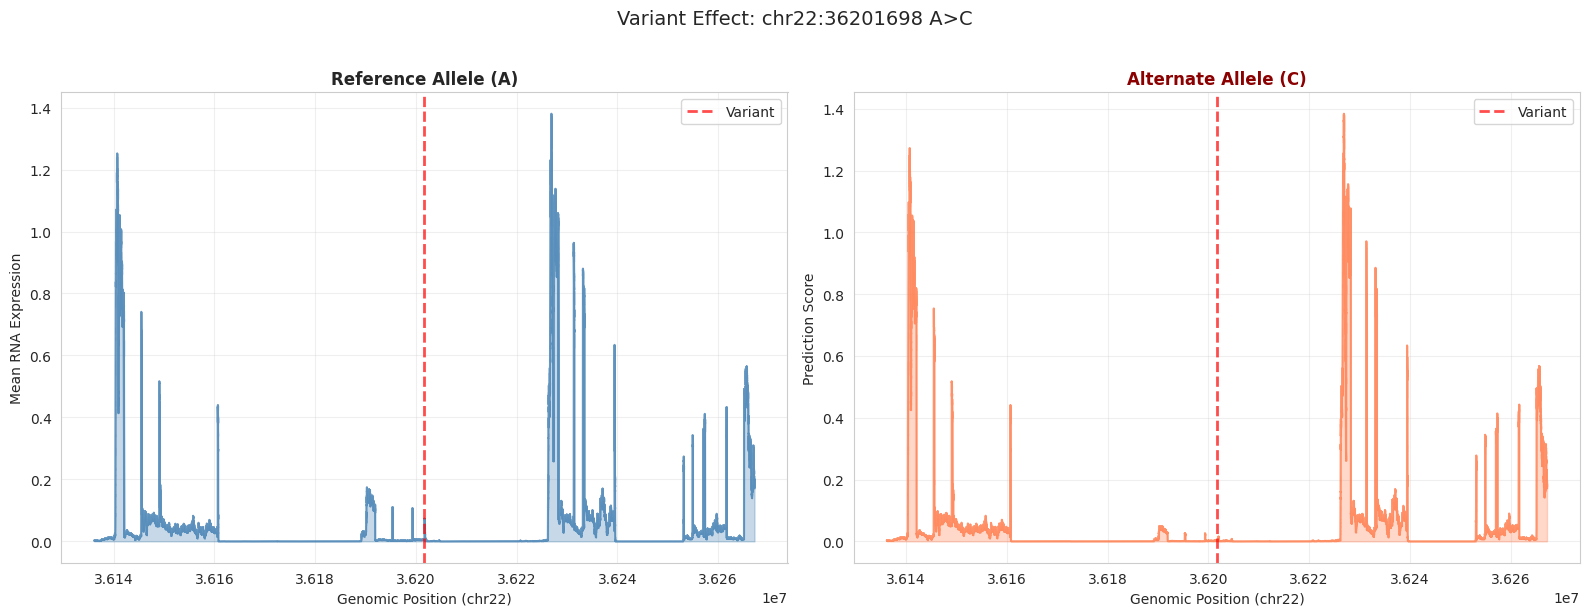

In [7]:
# 生成比较图
fig = plot_variant_comparison(
    ref_outputs=ref_outputs,
    alt_outputs=alt_outputs,
    variant=variant,
    figsize=(16, 6)
)

if fig:
    plt.show()
else:
    print("可视化不可用")

## 8. 计算效应评分

让我们量化参考和替代等位基因之间的差异。

In [8]:
# 计算简单效应评分
# 注意: 实际实现取决于 AlphaGenome 输出结构

effect_score = {
    'variant': f"{variant.chromosome}:{variant.position}",
    'ref_allele': variant.reference_bases,
    'alt_allele': variant.alternate_bases,
    'predicted_effect': '未知'  # 将从实际数据计算
}

print("变异效应摘要:")
print(f"  位置: {effect_score['variant']}")
print(f"  变化: {effect_score['ref_allele']} → {effect_score['alt_allele']}")
print(f"  效应: {effect_score['predicted_effect']}")

变异效应摘要:
  位置: chr22:36201698
  变化: A → C
  效应: 未知


## 9. 保存分析结果

In [9]:
from pathlib import Path
import json

# 创建结果目录
results_dir = Path.home() / 'work' / 'results' / 'variant_analysis'
results_dir.mkdir(parents=True, exist_ok=True)

# 保存图表
if fig:
    fig_path = results_dir / 'variant_comparison.png'
    fig.savefig(fig_path, bbox_inches='tight', dpi=300)
    print(f"✓ 图表已保存: {fig_path}")

# 保存变异信息
variant_info_path = results_dir / 'variant_info.json'
with open(variant_info_path, 'w') as f:
    json.dump(effect_score, f, indent=2)
print(f"✓ 变异信息已保存: {variant_info_path}")

print(f"\n所有结果已保存到: {results_dir}")

✓ 图表已保存: /home/admin/work/results/variant_analysis/variant_comparison.png
✓ 变异信息已保存: /home/admin/work/results/variant_analysis/variant_info.json

所有结果已保存到: /home/admin/work/results/variant_analysis


## 10. 尝试您自己的变异

复制并修改此代码以分析不同的变异：

In [10]:
# 示例: 定义您自己的变异
# my_variant = genome.Variant(
#     chromosome='chr22',      # 更改染色体
#     position=36202000,        # 更改位置
#     reference_bases='G',     # 更改参考等位基因
#     alternate_bases='A'      # 更改替代等位基因
# )

# 然后使用您的变异运行预测
# outputs = model.predict_variant(...)

print("准备分析自定义变异！")

准备分析自定义变异！


## 总结

在本 notebook 中，您学习了如何：

✓ 定义遗传变异  
✓ 设置用于分析的基因组上下文  
✓ 运行变异效应预测  
✓ 比较参考与替代等位基因  
✓ 可视化变异效应  
✓ 保存分析结果  

### 相关 Notebooks:
- **01_quickstart.ipynb** - 基本序列预测
- **03_batch_analysis.ipynb** - 一次分析多个变异
- **04_visualization.ipynb** - 高级可视化技术

### 提示:
- 始终定义变异周围的区间
- 较大的区间提供更多上下文但需要更长时间
- 监控您的 API 配额以避免达到限制